In [ ]:
#imput pelo googlecolab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/Colab Notebooks/Dataset/building.zip'
#salvar o dataset no gdrive e mudar caminho quem for o rodar
#file_name = '/content/gdrive/MyDrive/etc...'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!git clone https://github.com/crowdAI/mapping-challenge-starter-kit

fatal: destination path 'mapping-challenge-starter-kit' already exists and is not an empty directory.


In [ ]:
cd mapping-challenge-starter-kit

/content/mapping-challenge-starter-kit


In [ ]:
pip install git+https://github.com/crowdai/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/crowdai/coco.git to /tmp/pip-req-build-0pmmo9vi
  Running command git clone --filter=blob:none --quiet https://github.com/crowdai/coco.git /tmp/pip-req-build-0pmmo9vi
  Resolved https://github.com/crowdai/coco.git to commit d321db87d05de8e00cc32d05c385b5898d598cf9
  Preparing metadata (setup.py) ... done


In [ ]:
!ls

 cocoeval.py	       'Local Evaluation.ipynb'    random_submission.py
 data		        log_file_name.zip	   README.md
'Dataset Utils.ipynb'  'Random Submission.ipynb'   requirements.txt


In [ ]:
pip install -r requirements.txt

  Using cached awscli-1.14.50-py2.py3-none-any.whl (1.2 MB)
  Using cached botocore-1.9.3-py2.py3-none-any.whl (4.1 MB)
  Using cached certifi-2018.4.16-py2.py3-none-any.whl (150 kB)
  Using cached cffi-1.11.5.tar.gz (438 kB)
  Preparing metadata (setup.py) ... done
  Using cached colorama-0.3.7-py2.py3-none-any.whl (19 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached Cython-0.28.1.tar.gz (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "/content/mapping-challenge-starter-kit/data/train/images"
TRAIN_ANNOTATIONS_PATH = "/content/mapping-challenge-starter-kit/data/train/annotation.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "/content/mapping-challenge-starter-kit/data/train/annotation-small.json"


In [ ]:
import shutil

# parei aqui

In [ ]:
original = '/content/train'
target = '/content/mapping-challenge-starter-kit/data'

shutil.move(original, target)

In [ ]:
original = '/content/annotation-small.json'
target = '/content/mapping-challenge-starter-kit/data/train'

shutil.move(original, target)

In [ ]:
original = '/content/annotation.json'
target = '/content/mapping-challenge-starter-kit/data/train'

shutil.move(original, target)

'/content/mapping-challenge-starter-kit/data/train/annotation.json'

# continuei aqui

**Trabalhando com o dataset parcial**

In [ ]:
coco = COCO(TRAIN_ANNOTATIONS_SMALL_PATH)

loading annotations into memory...
Done (t=1.31s)
creating index...
index created!


In [ ]:
category_ids = coco.loadCats(coco.getCatIds())
print(category_ids)

[{'id': 100, 'name': 'building', 'supercategory': 'building'}]


In [ ]:
# This generates a list of all `image_ids` available in the dataset
image_ids = coco.getImgIds(catIds=coco.getCatIds())

In [ ]:
len(image_ids)

8366

In [ ]:
divisao = 12
n_samples = int(len(image_ids)/divisao)
print(n_samples)

697


In [ ]:
image_ids_part1 = image_ids[:int(len(image_ids)/divisao)]

**código treinamento U-NET**

In [ ]:
pip install segmentation-models==1.0.1

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
#os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
from PIL import Image
import os

from matplotlib import gridspec
import time

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import argparse
from tensorflow.keras.layers import Input
from keras import backend as K
import os
import keras
import logging
import io
from contextlib import redirect_stdout
from datetime import datetime

Segmentation Models: using `tf.keras` framework.


In [ ]:
def save_model_summary(model, log_file_path, log_file_name, backbone_name, history):
    """
    Save the model architecture to a JSON file
    """
    model_json = model.to_json()
    json_file_path = log_file_path + '_architecture.json'
    with open(json_file_path, 'w') as json_file:
        json_file.write(model_json)
    logging.info(f'Model architecture saved to: {json_file_path}')

    """# Save the model summary to a text file
    summary_stream = io.StringIO()
    with redirect_stdout(summary_stream):
        model.summary()

    summary_file_path = log_file_path + log_file_name + '_summary.txt'
    with open(summary_file_path, 'w') as summary_file:
        summary_file.write(summary_stream.getvalue())
        summary_file.write(backbone_name)
        summary_file.write(str(history.history))
    logging.info(f'Model summary saved to: {summary_file_path}')"""

In [ ]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == 0,axis=-1)] = 1
    label_seg [np.all(label==1,axis=-1)] = 0
#     label_seg [np.all(label == "any",axis=-1)] = 2

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

**preparing the dataset**

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
def get_generator_image_dataset(image_ids_part1,coco,TRAIN_IMAGES_DIRECTORY):
    for idx, image in enumerate(image_ids_part1):

        #getting the image from the dataset
        img = coco.loadImgs(image)[0]
        #print(img["file_name"])
        image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
        I = io.imread(image_path)
        img_resized = cv2.resize(I,(256,256))

        #generating the mask
        annotation_ids = coco.getAnnIds(imgIds=img['id'])
        annotations = coco.loadAnns(annotation_ids)


        yield img_resized

In [ ]:
image_dataset_gen = get_generator_image_dataset(image_ids_part1,coco,TRAIN_IMAGES_DIRECTORY)

In [ ]:
def get_generator_mask_dataset(image_ids_part1,coco,TRAIN_IMAGES_DIRECTORY):
    for idx, image in enumerate(image_ids_part1):

        img = coco.loadImgs(image)[0]
        #print(img["file_name"])
        image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
        I = io.imread(image_path)
        img_resized = cv2.resize(I,(256,256))

        #generating the mask
        annotation_ids = coco.getAnnIds(imgIds=img['id'])
        annotations = coco.loadAnns(annotation_ids)


        #generating the mask
        annotation_ids = coco.getAnnIds(imgIds=img['id'])
        annotations = coco.loadAnns(annotation_ids)

        mask_complete = np.zeros((300,300), dtype='uint8')
        for _idx, annotation in enumerate(annotations):

          rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
          m = cocomask.decode(rle)
          # m.shape has a shape of (300, 300, 1)
          # so we first convert it to a shape of (300, 300)
          m = m.reshape((img['height'], img['width']))

          mask_complete+=m
        mask_complete = cv2.resize(mask_complete,(256,256))
        mask_complete = np.repeat(mask_complete[:, :, np.newaxis], 3, axis=2)
        yield mask_complete

In [ ]:
mask_dataset_gen = get_generator_mask_dataset(image_ids_part1,coco,TRAIN_IMAGES_DIRECTORY)

In [ ]:
image_dataset = np.zeros((0,256,256,3))

for i in image_dataset_gen:
    image_dataset = np.concatenate([image_dataset, np.expand_dims(np.array(i), axis=0)], axis=0)

In [ ]:
mask_dataset = np.zeros((0,256,256,3))

for idx, i in enumerate(mask_dataset_gen):
    mask_dataset = np.concatenate([mask_dataset, np.expand_dims(np.array(i), axis=0)], axis=0)


**spliting train/val**

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
print("labels.shape: ", labels.shape)
#labels = np.expand_dims(labels, axis=3)

# Making into one-hot encoding since the array has integers
n_classes = len(np.unique(labels))
print("numero de classes: ", n_classes)
labels_cat = to_categorical(labels, num_classes=n_classes)
print("labels_cat.shape: ", labels_cat.shape)

labels.shape:  (697, 256, 256)
numero de classes:  2
labels_cat.shape:  (697, 256, 256, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.30, random_state = 42)

In [ ]:
print("X_train[0].dtype: ", X_train[0].dtype)
print("y_train[0].dtype: ", y_train[0].dtype)
print("X_test[0].dtype: ", X_test[0].dtype)
print("y_test[0].dtype: ", y_test[0].dtype)

print('X_train_size: ', X_train.shape)
print('y_train_size: ', y_train.shape)
print('X_test_size: ', X_test.shape)
print('y_test_size: ', y_test.shape)

X_train[0].dtype:  float64
y_train[0].dtype:  float32
X_test[0].dtype:  float64
y_test[0].dtype:  float32
X_train_size:  (365, 256, 256, 3)
y_train_size:  (365, 256, 256, 2)
X_test_size:  (157, 256, 256, 3)
y_test_size:  (157, 256, 256, 2)


In [ ]:
# Using resnet backbone on unet with imagenet weights
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model: pretrained weights
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

inp = Input(shape=(None, None, 3))
layer_1 = tf.keras.layers.Conv2D(3, (1, 1))(inp) # map N channels data to 2 channels
out = model_resnet_backbone(layer_1)
model_resnet_backbone = tf.keras.Model(inp, out, name=model_resnet_backbone.name)
model_resnet_backbone.summary()

metrics=['accuracy', jacard_coef]

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

model_resnet_backbone.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= metrics)
#model_resnet_backbone.compile(optimizer=optimizer, loss='binary_crossentropy', metrics= metrics)
print(model_resnet_backbone.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     12        
                                                                 
 model (Functional)          (None, None, None, 2)     75048242  
                                                                 
Total params: 75048254 (286.29 MB)
Trainable params: 74735550 (285.09 MB)
Non-trainable params: 312704 (1.19 MB)
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 

** não esquecer de criar pasta /model na raiz manualmente**

In [ ]:
cd /content/

/content


In [ ]:
!mkdir model

Epoch 1/8
122/122 [==============================] - 235s 645ms/step - loss: 0.3824 - accuracy: 0.8449 - jacard_coef: 0.5976 - val_loss: 0.2974 - val_accuracy: 0.8941 - val_jacard_coef: 0.6541 - lr: 1.0000e-04
Epoch 2/8
122/122 [==============================] - 64s 525ms/step - loss: 0.2496 - accuracy: 0.9028 - jacard_coef: 0.7240 - val_loss: 0.2494 - val_accuracy: 0.9124 - val_jacard_coef: 0.7168 - lr: 1.0000e-04
Epoch 3/8
122/122 [==============================] - 59s 487ms/step - loss: 0.2167 - accuracy: 0.9153 - jacard_coef: 0.7614 - val_loss: 0.1943 - val_accuracy: 0.9266 - val_jacard_coef: 0.7793 - lr: 1.0000e-04
Epoch 4/8
122/122 [==============================] - 64s 528ms/step - loss: 0.1928 - accuracy: 0.9250 - jacard_coef: 0.7882 - val_loss: 0.1862 - val_accuracy: 0.9256 - val_jacard_coef: 0.7947 - lr: 1.0000e-04
Epoch 5/8
122/122 [==============================] - 49s 402ms/step - loss: 0.1730 - accuracy: 0.9322 - jacard_coef: 0.8079 - val_loss: 0.1866 - val_accuracy: 0.93

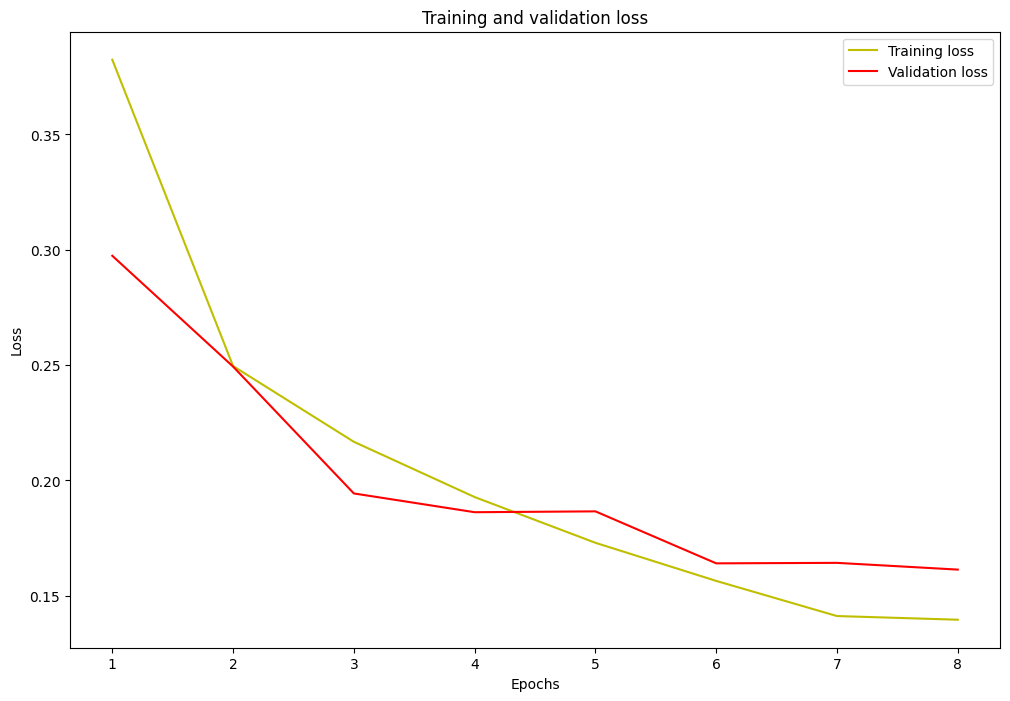

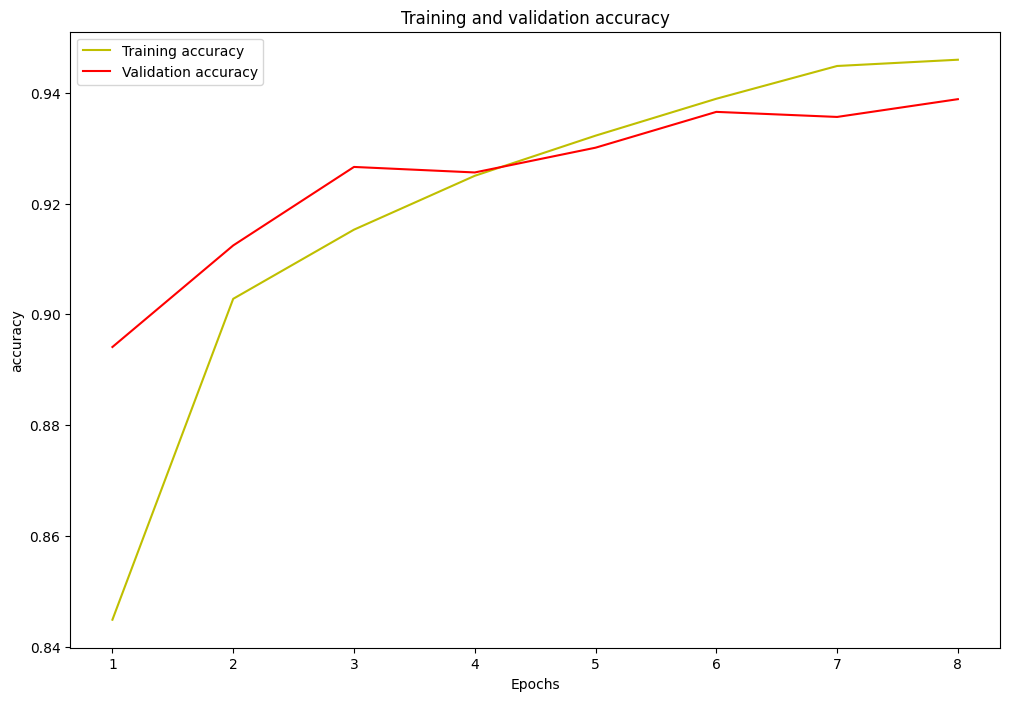

In [ ]:
main_loc = '/content/'
model_path_to_save = '/model'
log_file_path = os.path.join(main_loc + model_path_to_save)
log_file_name = 'best_model_backbone_' + BACKBONE + '_' + datetime.now().strftime("%m%d%Y%H%M%S") + '.h5'

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(log_file_path, log_file_name),
        save_weights_only=True,
        save_best_only=True,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(),
]

history2=model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=4,
          epochs=8,
          verbose=1,
          callbacks=callbacks,
          validation_data=(X_test_prepr, y_test))

save_model_summary(model_resnet_backbone, log_file_path, log_file_name, BACKBONE, history2)

history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig(os.path.join(log_file_path, log_file_name + '_loss_curve.png'))

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
#plt.show()
plt.savefig(os.path.join(log_file_path, log_file_name + '_acc_curve.png'))

print('end')

# Model evaluation
y_pred=model_resnet_backbone.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

print(jacard_coef(y_test,y_pred))
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax,y_pred_argmax)
print(IOU_keras.result().numpy())
print(dice_coef(y_test,y_pred).numpy())


In [ ]:
cd /content

/content


In [ ]:
!zip -r log_file_name.zip /content/model/

updating: content/model/ (stored 0%)
updating: content/model/.ipynb_checkpoints/ (stored 0%)
  adding: content/model/best_model_backbone_efficientnetb7_03312024230945.h5_acc_curve.png (deflated 13%)
  adding: content/model/best_model_backbone_efficientnetb7_03312024230945.h5 (deflated 7%)
  adding: content/model/best_model_backbone_efficientnetb7_03312024230945.h5_loss_curve.png (deflated 15%)


In [ ]:
!mkdir prediction_results

mkdir: cannot create directory ‘prediction_results’: File exists


In [ ]:
number_of_test_samples = 4
for single_image_id in image_ids[n_samples+2:n_samples+2+number_of_test_samples]:

    #single_image_id = image_ids[n_samples+2]

    img = coco.loadImgs(single_image_id)[0]
    image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
    I = io.imread(image_path)
    img_resized = cv2.resize(I,(256,256))

    #generating the mask
    annotation_ids = coco.getAnnIds(imgIds=img['id'])
    annotations = coco.loadAnns(annotation_ids)

    mask_complete = np.zeros((300,300), dtype='uint8')
    for _idx, annotation in enumerate(annotations):

      rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
      m = cocomask.decode(rle)
      # m.shape has a shape of (300, 300, 1)
      # so we first convert it to a shape of (300, 300)
      m = m.reshape((img['height'], img['width']))

      mask_complete+=m
    mask_complete = cv2.resize(mask_complete,(256,256))

    single_image = preprocess_input(img_resized)
    test_img_input=np.expand_dims(single_image, 0)
    prediction = (model_resnet_backbone.predict(test_img_input)[0,:,:,0] > 0.7).astype(np.uint8)
    plt.imsave("/content/prediction_results/" + img["file_name"], prediction)
    plt.imsave("/content/prediction_results/" + 'GT_'+ img["file_name"], mask_complete)

1/1 [==============================] - 0s 54ms/step


In [ ]:
!zip -r prediction_results.zip /content/prediction_results/

  adding: content/prediction_results/ (stored 0%)
  adding: content/prediction_results/GT_000000035344.jpg (deflated 22%)
  adding: content/prediction_results/GT_000000068111.jpg (deflated 16%)
  adding: content/prediction_results/GT_000000002592.jpg (deflated 8%)
  adding: content/prediction_results/000000100900.jpg (deflated 8%)
  adding: content/prediction_results/000000035344.jpg (deflated 12%)
  adding: content/prediction_results/.ipynb_checkpoints/ (stored 0%)
  adding: content/prediction_results/000000002592.jpg (deflated 9%)
  adding: content/prediction_results/000000068111.jpg (deflated 10%)
  adding: content/prediction_results/GT_000000100900.jpg (deflated 15%)


In [ ]:
plt.imsave("/content/prediction.jpg", prediction)
#plt.imshow(mask_complete)

In [ ]:
# test_img_number = random.randint(0, len(X_test))
test_img_number = 5
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_resnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
#predicted_img=np.argmax(prediction, axis=3)

**rascunhos**

In [ ]:
"""perc_train = 0.7
perc_test = 1 - perc_train
n_train_samples = int(n_samples*perc_train)
n_test_samples = n_samples - n_train_samples

print("n_train_samples: ",n_train_samples)
print("n_test_samples: ", n_test_samples)"""

n_train_samples:  731
n_test_samples:  314


In [ ]:
"""# i (256,256,3)
X_train = np.zeros((0,256,256,3))
X_test  = np.zeros((0,256,256,3))

#creating X_train and X_test
for idx, i in enumerate(image_dataset_gen):
    if idx <= n_train_samples:
        X_train = np.concatenate([X_train, np.expand_dims(np.array(i), axis=0)], axis=0)
    else:
        X_test  = np.concatenate([X_test, np.expand_dims(np.array(i), axis=0)], axis=0)"""


In [ ]:
"""print(X_train.shape)
print(type(X_train))"""

(732, 256, 256, 3)
<class 'numpy.ndarray'>


In [ ]:
"""print(X_test.shape)
print(type(X_test))"""

(313, 256, 256, 3)
<class 'numpy.ndarray'>


In [ ]:
for idx, image in enumerate(image_ids):

  #getting the image from the dataset
  img = coco.loadImgs(image)[0]
  #print(img["file_name"])
  image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
  shutil.copy(image_path, main_directory + image_directory + img["file_name"])
  #generating the mask
  annotation_ids = coco.getAnnIds(imgIds=img['id'])
  annotations = coco.loadAnns(annotation_ids)

  mask_complete = np.zeros((300,300), dtype='uint8')
  for _idx, annotation in enumerate(annotations):

      rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
      m = cocomask.decode(rle)
      # m.shape has a shape of (300, 300, 1)
      # so we first convert it to a shape of (300, 300)
      m = m.reshape((img['height'], img['width']))

      mask_complete+=m
  #plt.imshow(mask_complete)
  plt.imsave(main_directory + mask_directory + img["file_name"], mask_complete)


In [ ]:
shutil.make_archive('/content/dataset_building', 'zip', '/content/')

OSError: [Errno 95] Operation not supported: '/content/gdrive/MyDrive/Report Marco.zdoc'

In [ ]:
"""main_loc = '/content/3'

image_dataset = []
mask_dataset  = []

for idx, image in enumerate(image_ids_part1):

    #getting the image from the dataset
    img = coco.loadImgs(image)[0]
    #print(img["file_name"])
    image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
    I = io.imread(image_path)
    img_resized = cv2.resize(I,(256,256))

    #image_dataset.append(img_resized)
    image_dataset_gen = get_generator_image_dataset(img_resized)

    #generating the mask
    annotation_ids = coco.getAnnIds(imgIds=img['id'])
    annotations = coco.loadAnns(annotation_ids)

    mask_complete = np.zeros((300,300), dtype='uint8')
    for _idx, annotation in enumerate(annotations):

      rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
      m = cocomask.decode(rle)
      # m.shape has a shape of (300, 300, 1)
      # so we first convert it to a shape of (300, 300)
      m = m.reshape((img['height'], img['width']))

      mask_complete+=m
    mask_complete = cv2.resize(mask_complete,(256,256))
    #mask_dataset.append(mask_complete)
    mask_dataset_gen = get_generator_mask_dataset(mask_complete)
#mask_dataset =  np.array(mask_dataset)
#image_dataset =  np.array(image_dataset)"""


In [ ]:
!zip -r dataset_building.zip /content/dataset_building

In [ ]:
ls

In [ ]:
original = './dataset_building.zip'
target = '/content/dataset_building.zip'

shutil.move(original, target)

'/content/dataset_building.zip'

In [ ]:
original = '/content/dataset_building.zip'
target = '/content/gdrive/MyDrive/Colab Notebooks/Dataset/dataset_building.zip'

shutil.move(original, target)

'/content/gdrive/MyDrive/Colab Notebooks/Dataset/dataset_building.zip'

**carregar aqui as imagens**

**treinando o modelo**

In [ ]:
def save_model_summary(model, log_file_path, log_file_name, backbone_name, history):
    """
    Save the model architecture to a JSON file
    """
    model_json = model.to_json()
    json_file_path = log_file_path + '_architecture.json'
    with open(json_file_path, 'w') as json_file:
        json_file.write(model_json)
    logging.info(f'Model architecture saved to: {json_file_path}')

    # Save the model summary to a text file
    summary_stream = io.StringIO()
    with redirect_stdout(summary_stream):
        model.summary()

    summary_file_path = log_file_path + log_file_name + '_summary.txt'
    with open(summary_file_path, 'w') as summary_file:
        summary_file.write(summary_stream.getvalue())
        summary_file.write(backbone_name)
        summary_file.write(str(history.history))
    logging.info(f'Model summary saved to: {summary_file_path}')

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [ ]:
list_of_images = os.listdir()
image_dataset